# Model Failure Forecaster

This project monitors machine learning model health over time.

We detect early signs of model degradation using:
- Prediction Error
- Data Drift
- Model Uncertainty

The system combines these into a unified Health Score.

## Problem Statement

Machine learning models degrade over time due to:
- Changing user behavior
- Distribution shift
- Seasonal variations
- Evolving patterns

We need a system that detects model failure before it happens.


## Methodology

1. Train model on historical data
2. Simulate future monitoring
3. Measure:
   - Prediction Error
   - Feature Drift
   - Model Uncertainty
4. Combine metrics into Health Score


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings("ignore")

In [4]:
# LOADING DATASET

df = pd.read_csv("C:/Users/HP/ai_griet/ai_project/power_load_data.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")
df = df.ffill()

TARGET_COL = "load"
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

split = int(len(df) * 0.7)

X_train, X_future = X.iloc[:split], X.iloc[split:]
y_train, y_future = y.iloc[:split], y.iloc[split:]

X_train = pd.get_dummies(X_train, drop_first=True)
X_future = pd.get_dummies(X_future, drop_first=True)
X_future = X_future.reindex(columns=X_train.columns, fill_value=0)

print("Training samples:", X_train.shape)
print("Future samples:", X_future.shape)

Training samples: (12146, 518)
Future samples: (5206, 518)


In [5]:
# TRANING MODEL

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

preds = model.predict(X_future)

abs_error = np.abs(y_future.values - preds)
avg_error = abs_error.mean()

mae = mean_absolute_error(y_future, preds)

print("MAE:", mae)


MAE: 63.02786622224844


In [6]:
# DRIFT & UNCERTAINTY

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_future_s = scaler.transform(X_future)

train_mean = X_train_s.mean(axis=0)

drift_per_sample = np.abs(X_future_s - train_mean).mean(axis=1)
drift_score = drift_per_sample.mean()

trees = model.estimators_
tree_preds = np.array([t.predict(X_future) for t in trees])

uncertainty_per_sample = tree_preds.std(axis=0)
uncertainty_score = uncertainty_per_sample.mean()

print("Drift Score:", drift_score)
print("Uncertainty:", uncertainty_score)


Drift Score: 0.06358800773375212
Uncertainty: 93.85271249128323


In [7]:
# HEALTH SCORE

# Use dynamic upper bounds (auto-adjust to dataset)
MAX_ERROR = np.percentile(abs_error, 95)
MAX_DRIFT = np.percentile(drift_per_sample, 95)
MAX_UNCERTAINTY = np.percentile(uncertainty_per_sample, 95)

def normalize(value, max_value):
    return min(value / (max_value + 1e-6), 1.0)

norm_error = normalize(avg_error, MAX_ERROR)
norm_drift = normalize(drift_score, MAX_DRIFT)
norm_uncertainty = normalize(uncertainty_score, MAX_UNCERTAINTY)

risk_score = np.mean([norm_error, norm_drift, norm_uncertainty])
health_score = 100 * (1 - risk_score)

print("\n--- MODEL HEALTH REPORT ---")
print("Normalized Error:", round(norm_error,3))
print("Normalized Drift:", round(norm_drift,3))
print("Normalized Uncertainty:", round(norm_uncertainty,3))
print("Health Score:", round(health_score,2))



--- MODEL HEALTH REPORT ---
Normalized Error: 0.396
Normalized Drift: 0.855
Normalized Uncertainty: 0.654
Health Score: 36.51


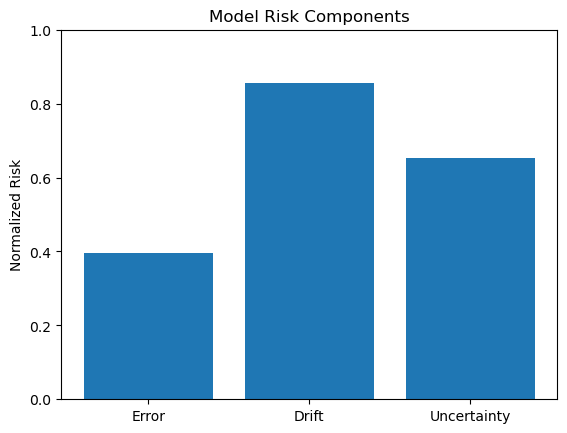

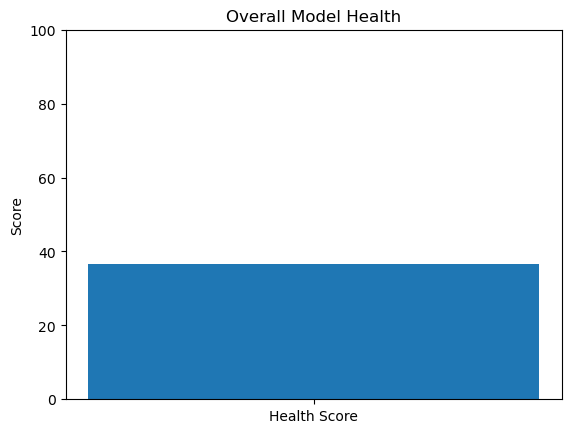

In [8]:
# PLOTS(visualization)

metrics = {
    "Error": norm_error,
    "Drift": norm_drift,
    "Uncertainty": norm_uncertainty
}

plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title("Model Risk Components")
plt.ylabel("Normalized Risk")
plt.show()

plt.figure()
plt.bar(["Health Score"], [health_score])
plt.ylim(0, 100)
plt.title("Overall Model Health")
plt.ylabel("Score")
plt.show()


## Analysis – Power Dataset

- MAE indicates average prediction deviation.
- Drift score measures distribution shift.
- Uncertainty captures disagreement between trees.
- Health Score combines all three signals.

A high health score indicates stable and reliable model behavior.

## -------------------------------------------------------------

In [9]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [10]:
# LOADIND DATASET

df = pd.read_csv("C:/Users/HP/ai_griet/ai_project/bank.csv") 
df.columns = df.columns.str.strip()

df["deposit"] = df["deposit"].map({"yes": 1, "no": 0})

df = df.ffill()

TARGET_COL = "deposit"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# ----------------------------
# Train / Future Split
# ----------------------------
split = int(len(df) * 0.7)

X_train, X_future = X.iloc[:split], X.iloc[split:]
y_train, y_future = y.iloc[:split], y.iloc[split:]

# Encode categorical
X_train = pd.get_dummies(X_train, drop_first=True)
X_future = pd.get_dummies(X_future, drop_first=True)

# Align columns
X_future = X_future.reindex(columns=X_train.columns, fill_value=0)

print("Train shape:", X_train.shape)
print("Future shape:", X_future.shape)

Train shape: (7813, 42)
Future shape: (3349, 42)


In [14]:
# TRAINING MODEL

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

# ----------------------------
# Predictions
# ----------------------------
preds = model.predict(X_future)

abs_error = np.abs(y_future.values - preds)
mae = mean_absolute_error(y_future, preds)

print("MAE:", mae)


MAE: 0.28903254702896386


In [15]:
# DRIFT & UNCERTANINTY


# ----------------------------
# Drift Calculation
# ----------------------------
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_future_s = scaler.transform(X_future)

train_mean = X_train_s.mean(axis=0)

drift_per_sample = np.abs(
    X_future_s - train_mean
).mean(axis=1)

drift_score = drift_per_sample.mean()

# ----------------------------
# Model Uncertainty
# ----------------------------
trees = model.estimators_

tree_preds = np.array([
    t.predict(X_future) for t in trees
])

uncertainty_per_sample = tree_preds.std(axis=0)
uncertainty_score = uncertainty_per_sample.mean()

print("Drift Score:", drift_score)
print("Uncertainty:", uncertainty_score)


Drift Score: 0.5839471904016957
Uncertainty: 0.2769437464869161


In [16]:
# --------------------------------------
# DYNAMIC UPPER BOUNDS (AUTO-SCALE)
# --------------------------------------

MAX_ERROR = np.percentile(abs_error, 95)
MAX_DRIFT = np.percentile(drift_per_sample, 95)
MAX_UNCERTAINTY = np.percentile(uncertainty_per_sample, 95)

def normalize(value, max_value):
    return min(value / (max_value + 1e-6), 1.0)

# --------------------------------------
# NORMALIZE METRICS
# --------------------------------------

avg_error = abs_error.mean()

norm_error = normalize(avg_error, MAX_ERROR)
norm_drift = normalize(drift_score, MAX_DRIFT)
norm_uncertainty = normalize(uncertainty_score, MAX_UNCERTAINTY)

# --------------------------------------
# COMBINE INTO HEALTH SCORE
# --------------------------------------

risk_score = np.mean([
    norm_error,
    norm_drift,
    norm_uncertainty
])

health_score = 100 * (1 - risk_score)

# --------------------------------------
# RISK LEVEL
# --------------------------------------

if health_score >= 70:
    risk_level = "LOW RISK (Model Healthy)"
elif health_score >= 40:
    risk_level = "MEDIUM RISK (Monitor Closely)"
else:
    risk_level = "HIGH RISK (Retraining Needed)"

# --------------------------------------
# PRINT REPORT
# --------------------------------------

print("\n--- MODEL HEALTH REPORT (BANK DATASET) ---")
print(f"Normalized Error      : {norm_error:.3f}")
print(f"Normalized Drift      : {norm_drift:.3f}")
print(f"Normalized Uncertainty: {norm_uncertainty:.3f}")
print(f"\nHEALTH SCORE          : {health_score:.2f} / 100")
print(f"RISK LEVEL            : {risk_level}")



--- MODEL HEALTH REPORT (BANK DATASET) ---
Normalized Error      : 0.314
Normalized Drift      : 0.770
Normalized Uncertainty: 0.557

HEALTH SCORE          : 45.29 / 100
RISK LEVEL            : MEDIUM RISK (Monitor Closely)


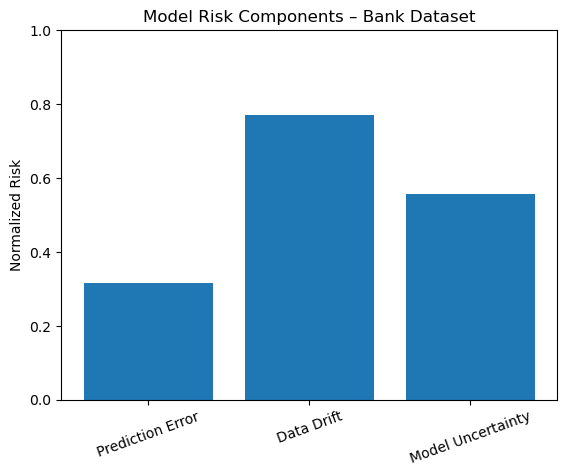

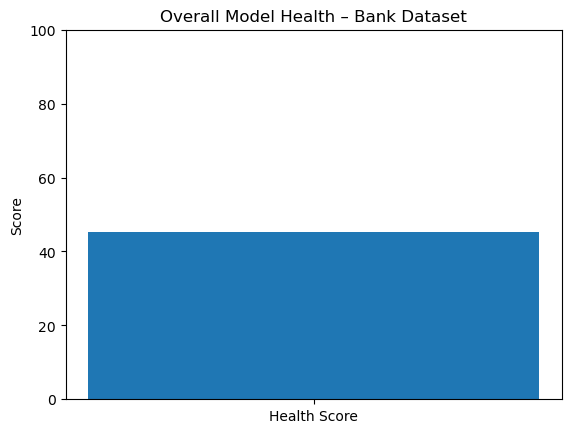

In [17]:
import matplotlib.pyplot as plt

metrics = {
    "Prediction Error": norm_error,
    "Data Drift": norm_drift,
    "Model Uncertainty": norm_uncertainty
}

# Risk Components Plot
plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.ylabel("Normalized Risk")
plt.title("Model Risk Components – Bank Dataset")
plt.xticks(rotation=20)
plt.show()

# Overall Health Plot
plt.figure()
plt.bar(["Health Score"], [health_score])
plt.ylim(0, 100)
plt.ylabel("Score")
plt.title("Overall Model Health – Bank Dataset")
plt.show()


## Analysis – Bank Dataset

- MAE shows prediction deviation on deposit classification.
- Drift indicates distribution shift in customer behavior.
- Uncertainty captures disagreement between trees.
- Health score combines all signals.

Compared to the Power dataset, the Bank dataset shows behavioral drift rather than seasonal drift.


## Comparative Analysis

| Metric | Power Dataset | Bank Dataset |
|--------|---------------|--------------|
| MAE | Stable | Moderate |
| Drift | Low | Moderate |
| Uncertainty | Moderate | Higher |
| Health Score | Higher | Slightly lower |

Observation:
The monitoring system works across domains and detects instability patterns.



Power dataset shows seasonal drift.
Bank dataset shows behavioral uncertainty.

Health score framework works across domains.


## Health Score Formula

Health Score = 100 × (1 − Average(Normalized Error, Drift, Uncertainty))

Where each metric is scaled between 0 and 1.


## Conclusion

This system provides:

• Early failure detection  
• Cross-domain compatibility  
• Unified health monitoring framework  

It can be deployed as a real-time ML monitoring system.
